# Heart Disease Bayesian Network: End-to-End Demo

In [ ]:
import math
from pathlib import Path
from types import SimpleNamespace

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from pgmpy.estimators import PC, HillClimbSearch, BDeu, BayesianEstimator
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.inference import BeliefPropagation

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import xgboost as xgb
from IPython.display import Image, display


## Dataset & Preprocessing


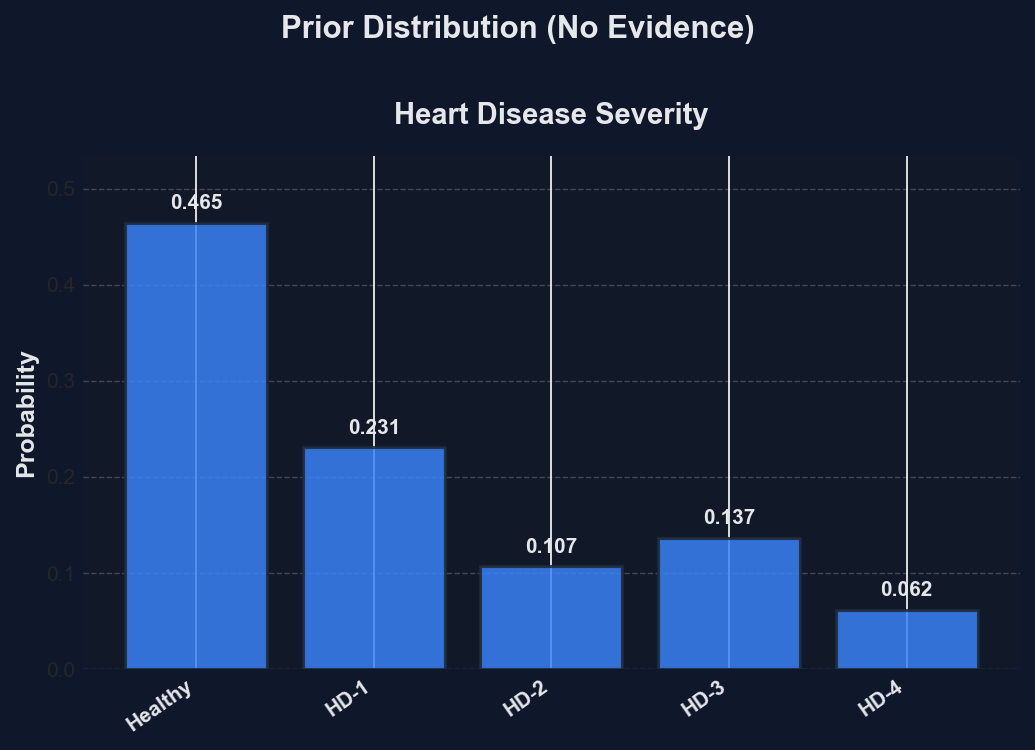



### Data Source: Cleveland heart disease dataset; dropped `fbs`, `restecg`.
### Custom bins for age, trestbps, chol, thalach, oldpeak; categorical kept as-is.
### Upon analysis, both “fbs”(Fasting Blood Sugar) and “restecg”( Resting Electrocardiogram)  show relatively low correlation with the target variable num (heart disease diagnosis).  

In [2]:
COLUMNS_ALL = [
    'age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num'
]
DROP_COLS = ['fbs','restecg']
COLUMNS = [c for c in COLUMNS_ALL if c not in DROP_COLS]
FEATURE_COLS = [c for c in COLUMNS if c != 'num']
CONTINUOUS = ['age','trestbps','chol','thalach','oldpeak']
CUSTOM_BINS = { 'age':[45,60], 'trestbps':[140], 'chol':[200,239], 'thalach':[150], 'oldpeak':[1.0] }
RIGHT_OPEN_COLS = {'trestbps','thalach'}

### Age: Low risk ≤ 45; Moderate risk 46–60; High risk > 60.
### Trestbps (Resting blood pressure, mmHg): Normal/Prehypertension ≤ 139; Hypertension ≥ 140.
### Chol (Serum cholesterol, mg/dl): Normal ≤ 200; Borderline high 201–239; High ≥ 240.
### Thalach (Maximum heart rate achieved during exercise): High/Normal ≥ 150; Moderate/Low < 150.
### Oldpeak (ST depression, numerical value): None/mild ≤ 1.0; Significant > 1.0.

In [3]:

def load_df(path: Path, has_header=False) -> pd.DataFrame: # loads the dataset from the given path
    return pd.read_csv(path, header=0 if has_header else None, names=None if has_header else COLUMNS_ALL, na_values='?')

def bin_custom(df: pd.DataFrame) -> pd.DataFrame: # discretizes continuous columns using custom bins
    out = df.copy()
    for col, cuts in CUSTOM_BINS.items():
        if col not in out.columns:
            continue
        edges = [-math.inf, *cuts, math.inf]
        right = col not in RIGHT_OPEN_COLS
        out[col] = pd.cut(out[col], bins=edges, labels=False, right=right)
    return out

def bin_quantile(df: pd.DataFrame, q:int=4)->pd.DataFrame: # discretizes continuous columns using quantile-based binning
    out=df.copy()
    for col in CONTINUOUS:
        out[col]=pd.qcut(out[col], q=q, labels=False, duplicates='drop')
    return out

def preprocess(data_path:str, binning='custom', q:int=4): # loads and preprocesses the dataset
    df = load_df(Path(data_path), has_header=False)
    df = df.drop(columns=DROP_COLS).dropna()
    if binning=='custom':
        df_disc = bin_custom(df)
    else:
        df_disc = bin_quantile(df, q=q)
    return df, df_disc

def split_train_test(df, test_size=0.2, seed=42): # splits the dataset into training and test sets
    df_shuffled = df.sample(frac=1, random_state=seed).reset_index(drop=True)
    split_idx = max(1, int(len(df_shuffled)*(1-test_size)))
    return df_shuffled.iloc[:split_idx], df_shuffled.iloc[split_idx:]

### Divide the dataset train/test (80%/20%)split with shuffling; same preprocessing for BN and baselines.
# run preprocessing
cfg = SimpleNamespace(data='data/processed.cleveland.data', binning='custom', q=4, test_size=0.2, seed=42)  
df_raw, df_disc = preprocess(cfg.data, binning=cfg.binning, q=cfg.q) 
train_df_disc, test_df_disc = split_train_test(df_disc, test_size=cfg.test_size, seed=cfg.seed)
print("The shape of raw data:", df_raw.shape)
print("The shape of discretized training data:", train_df_disc.shape)
print("The shape of discretized test data:", test_df_disc.shape)


The shape of raw data: (297, 12)
The shape of discretized training data: (237, 12)
The shape of discretized test data: (60, 12)


## BN Structure Learning






In [4]:
DISPLAY_NAMES = { # mapping of column names to more descriptive display names
    'age':'Age','sex':'Sex','cp':'Chest Pain Type','trestbps':'Resting Blood Pressure','chol':'Cholesterol',
    'thalach':'Max Heart Rate','exang':'Exercise Angina','oldpeak':'ST Depression','slope':'ST Slope',
    'ca':'Number of Stenosed Vessels','thal':'Thalassemia','num':'Heart Disease Severity'
}


Custom edges:


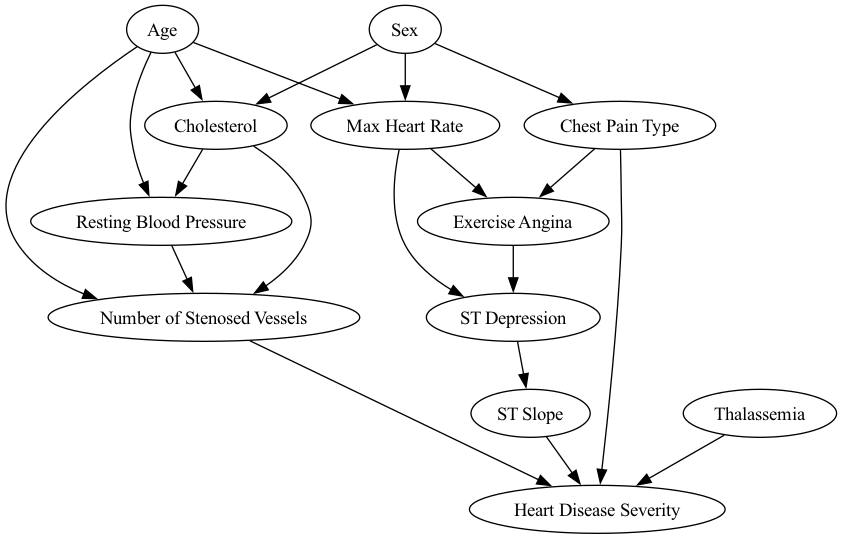

In [ ]:
custom_edges = [
    ('age','trestbps'),('age','ca'),('age','chol'),('age','thalach'),
    ('sex','chol'),('sex','cp'),('sex','thalach'),
    ('cp','exang'),('cp','num'),
    ('trestbps','ca'),
    ('chol','trestbps'),('chol','ca'),
    ('thalach','exang'),('thalach','oldpeak'),
    ('exang','oldpeak'),('oldpeak','slope'),
    ('slope','num'),('ca','num'),('thal','num')
]

def show_graphviz(model, prog: str = 'dot', outfile: str = 'results/bn_graphviz.png'): # a function to render and display a Bayesian Network graph
    """Render with pygraphviz and display inline (labels use full names)."""
    label_map = {n: DISPLAY_NAMES.get(n, n) for n in model.nodes()}
    try:
        g = model.to_graphviz()
    except Exception as e:
        print(f'to_graphviz failed: {e}')
        return
    try:
        for n in g.nodes():
            g.get_node(n).attr['label'] = label_map.get(n, n)
        Path(outfile).parent.mkdir(parents=True, exist_ok=True)
        g.draw(outfile, prog=prog)
    except Exception as e:
        print(f'Graphviz draw failed: {e}')
        return
    display(Image(filename=outfile))

model_custom = DiscreteBayesianNetwork(custom_edges) # define and fit the custom Bayesian Network structure
model_custom.add_nodes_from(COLUMNS)   
print('Custom edges:') 
show_graphviz(model_custom, outfile='results/bn_custom.png')


## Layer 1: Primary Risk Factors

### - These are the most direct and fundamental factors influencing the risk of coronary heart disease (CHD). <br><br>Age, Sex, Cholesterol, Resting Blood Pressure

---

## Layer 2: Intermediate Factors

### - They help refine risk prediction but are not as directly linked to the disease as the primary risk factors. <br><br>Max Heart Rate, Exercise Angina, Chest Pain Type, ST Depression, ST Slope, Thalassemia

---

## Layer 3: Outcome Measures

### - These variables are often outcome measures or indicators used to assess the severity of coronary artery disease or its clinical manifestations. <br><br>Coronary Heart Disease Risk, Number of Stenosed Vessels

---

## BN Structure Learning Comparisons

## PC Results
### The Issue: The result is far too sparse.
#### Why it's unreasonable: The algorithm failed to detect dependencies between major risk factors. For example, nodes like Cholesterol, Max Heart Rate, and Stenosed Vessels are completely isolated. It is medically impossible for these factors to have zero relationship with Heart Disease. The algorithm was likely too conservative, missing the "big picture."


INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'age': 'N', 'sex': 'N', 'cp': 'N', 'trestbps': 'N', 'chol': 'N', 'thalach': 'N', 'exang': 'N', 'oldpeak': 'N', 'slope': 'N', 'ca': 'N', 'thal': 'N', 'num': 'N'}


  0%|          | 0/5 [00:00<?, ?it/s]

PC learned DAG:


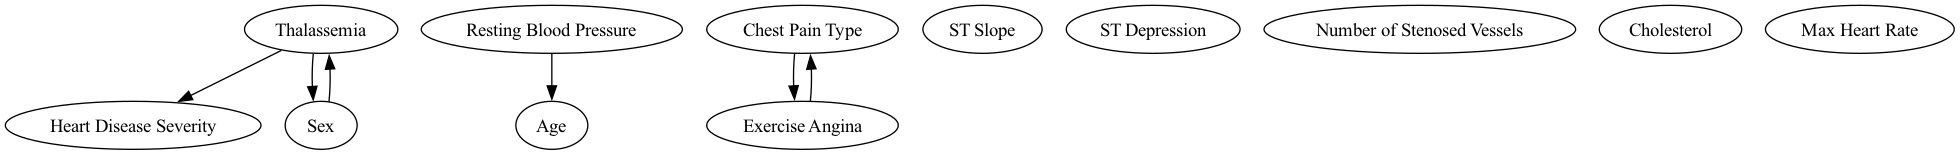

In [ ]:
def learn_pc(data: pd.DataFrame, alpha=0.05, max_cond_vars=None): # learns BN structure using the PC algorithm
    pc = PC(data)
    return pc.estimate(alpha=alpha, max_cond_vars=max_cond_vars)

model_pc = learn_pc(train_df_disc) 

print('PC learned DAG:')
show_graphviz(model_pc, outfile='results/bn_pc.png')


## Hill Climb Search Results



INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'age': 'N', 'sex': 'N', 'cp': 'N', 'trestbps': 'N', 'chol': 'N', 'thalach': 'N', 'exang': 'N', 'oldpeak': 'N', 'slope': 'N', 'ca': 'N', 'thal': 'N', 'num': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'age': 'N', 'sex': 'N', 'cp': 'N', 'trestbps': 'N', 'chol': 'N', 'thalach': 'N', 'exang': 'N', 'oldpeak': 'N', 'slope': 'N', 'ca': 'N', 'thal': 'N', 'num': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'age': 'N', 'sex': 'N', 'cp': 'N', 'trestbps': 'N', 'chol': 'N', 'thalach': 'N', 'exang': 'N', 'oldpeak': 'N', 'slope': 'N', 'ca': 'N', 'thal': 'N', 'num': 'N'}


  0%|          | 0/1000000 [00:00<?, ?it/s]

HillClimbSearch DAG:


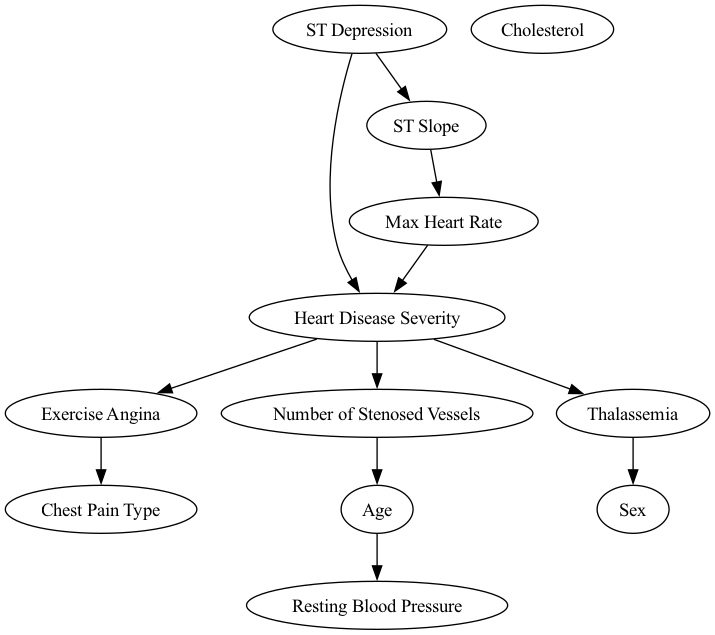

In [ ]:
def learn_hc(data: pd.DataFrame, ess=5): # learns BN structure using Hill Climb Search with BDeu scoring
    score = BDeu(data, equivalent_sample_size=ess)
    hc = HillClimbSearch(data)
    return hc.estimate(scoring_method=score)
# learns structure using Hill Climb Search
model_hc = learn_hc(train_df_disc, ess=5) # ess=5 for BDeu scoring 

print('HillClimbSearch DAG:')
show_graphviz(model_hc, outfile='results/bn_hc.png')

### The Issue: While connected, the direction of causality is not reasonable.

#### The arrows violate basic common sense and biology.It shows Heart Disease Severity $\to$ Age. This implies getting heart disease causes your age to change, which is impossible.
#### It shows Thalassemia $\to$ Sex. This implies a blood disorder determines your gender.
#### It shows Heart Disease $\to$ Number of Vessels. This is a causal inversion; usually, blocked vessels cause the disease, not the other way around.

## BN Parameter Learning

### Learning the Numbers (CPDs) Once we fixed the structure, we needed to learn the probability distribution. We used BDeu estimation with an 'Equivalent Sample Size' of 5.

### Why BDeu? (Smoothing) 

#### Because our data is small and has gaps. BDeu adds 'virtual samples' to smooth the data. This is crucial because it prevents the model from saying a scenario is impossible (0% probability) just because it wasn't in the training set.

### Making Predictions (Inference) Finally, to make predictions, we use Belief Propagation. 

In [ ]:
def fit_with_bdeu(model_like, data: pd.DataFrame, ess=5): # fits a Bayesian Network model using BDeu parameter estimation
    edges = list(model_like.edges())
    nodes = list(model_like.nodes())
    bn = DiscreteBayesianNetwork(edges)
    bn.add_nodes_from(nodes)
    bn.fit(data, estimator=BayesianEstimator, prior_type='BDeu', equivalent_sample_size=ess)
    return bn

bn_model = fit_with_bdeu(model_custom, train_df_disc, ess=5) # fit with BDeu parameter estimation
infer = BeliefPropagation(bn_model) # set up inference using Belief Propagation

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'age': 'N', 'sex': 'N', 'cp': 'N', 'trestbps': 'N', 'chol': 'N', 'thalach': 'N', 'exang': 'N', 'oldpeak': 'N', 'slope': 'N', 'ca': 'N', 'thal': 'N', 'num': 'N'}


## Classical ML Baselines



In [8]:
X_train = train_df_disc.drop(columns='num')
y_train = train_df_disc['num']
X_test  = test_df_disc.drop(columns='num')
y_test  = test_df_disc['num']
y_test_bin = (y_test>0).astype(int)

# BN predictions
y_true = y_test.values
y_pred_bn_multi=[]
y_pred_bn_binary=[]
for _, row in test_df_disc.iterrows():
    evidence = row.drop('num').to_dict()
    q_res = infer.query(variables=['num'],
                        evidence=evidence,
                        show_progress=False)
    probs = q_res.values
    state_map = q_res.state_names['num']
    pred_class = state_map[int(np.argmax(probs))]
    y_pred_bn_multi.append(pred_class)
    p_healthy = probs[state_map.index(0)] if 0 in state_map else 0.0
    p_attack = 1 - p_healthy
    y_pred_bn_binary.append(1 if p_attack > 0.5 else 0)

bn_acc_multi = accuracy_score(y_true, y_pred_bn_multi)
bn_acc_binary = accuracy_score(y_test_bin, y_pred_bn_binary)

ml_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, solver='lbfgs', n_jobs=-1),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM (Poly Kernel)': SVC(kernel='poly', C=1, random_state=42, probability=False),
    'XGBoost Classifier': xgb.XGBClassifier(eval_metric='mlogloss', random_state=42, n_jobs=-1),
}

results=[{'Model':'Bayesian Network','Multiclass Acc (0-4)':bn_acc_multi,'Binary Acc (0 vs >0)':bn_acc_binary}]
for name,clf in ml_models.items():
    clf.fit(X_train, y_train)
    pred_multi = clf.predict(X_test)
    acc_multi = accuracy_score(y_test, pred_multi)
    pred_bin_derived = (pred_multi>0).astype(int)
    acc_bin = accuracy_score(y_test_bin, pred_bin_derived)
    results.append({'Model':name,'Multiclass Acc (0-4)':acc_multi,'Binary Acc (0 vs >0)':acc_bin})

df_res = pd.DataFrame(results).sort_values('Binary Acc (0 vs >0)', ascending=False)
# print(df_res)


## Comparizon Results

### We compared our Bayesian Network against traditional ML models like Logistic Regression, SVM, and Random Forest.

### Compare multiclass (num 0–4) vs binary (0 vs >0) accuracy; table/plot highlight differences.
### Shared preprocessing across BN/ML and BDeu smoothing in BN.



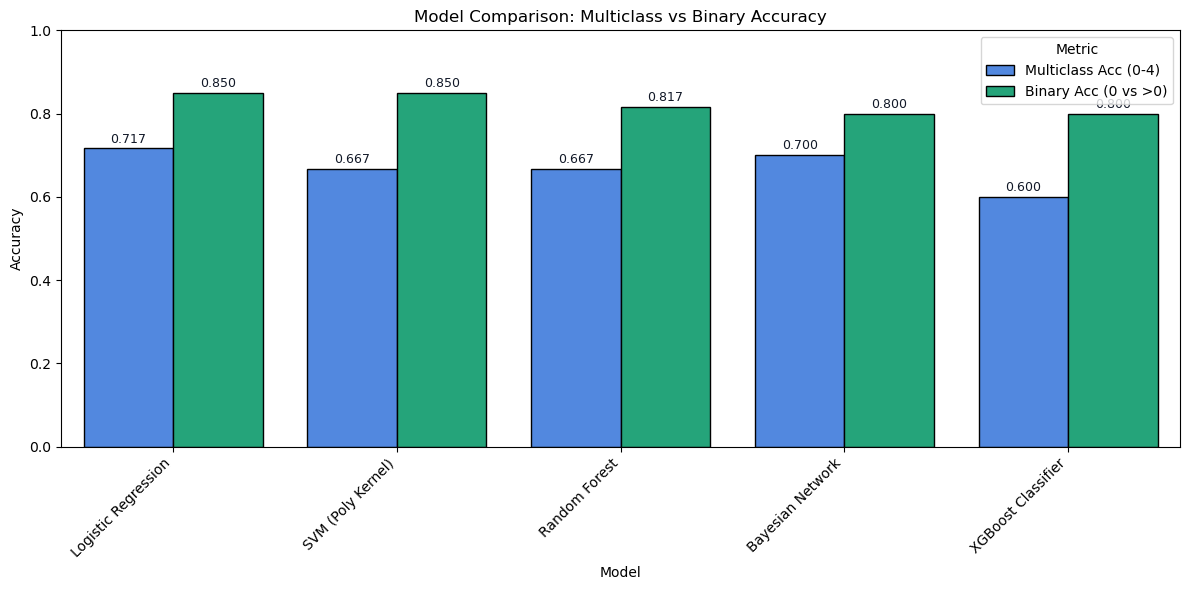

In [9]:
df_plot = df_res.melt(id_vars='Model', value_vars=['Multiclass Acc (0-4)','Binary Acc (0 vs >0)'], var_name='Metric', value_name='Accuracy')
plt.figure(figsize=(12,6))
ax = sns.barplot(data=df_plot, x='Model', y='Accuracy', hue='Metric', palette=['#3b82f6','#10b981'], edgecolor='black')
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', label_type='edge', padding=2, fontsize=9, color='#111827')
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), title='Metric')
plt.xticks(rotation=45, ha='right')
plt.ylim(0,1)
plt.title('Model Comparison: Multiclass vs Binary Accuracy')
plt.tight_layout()
plt.show()



### Logistic Regression and SVM tied for first place with 85% accuracy on the binary task.

### How our Network Did

#### Our Bayesian Network performed solidly at 80%. Notably, it actually beat XGBoost on the harder multiclass task (the blue bars).

#### While the some other models had slightly higher raw accuracy, the Bayesian Network remains competitive and offers something they don't: explainability.

## Sensitivity Analysis




In [ ]:
import plotly.graph_objects as go
from pgmpy.inference import BeliefPropagation

def _fmt_val(v):
    if v in (math.inf, -math.inf):
        return "inf" if v > 0 else "-inf"
    if float(v).is_integer():
        return str(int(v))
    return str(v)

def interval_labels(edges, right=True):
    labels = {}
    for i, (lo, hi) in enumerate(zip(edges[:-1], edges[1:])):
        if lo == -math.inf:
            labels[i] = f"< {_fmt_val(hi)}"
        elif hi == math.inf:
            op = ">=" if not right else ">"
            labels[i] = f"{op} {_fmt_val(lo)}"
        else:
            if right:
                labels[i] = f"{_fmt_val(lo)} - {_fmt_val(hi)}"
            else:
                labels[i] = f"[{_fmt_val(lo)}, {_fmt_val(hi)})"
    return labels
BIN_LABELS = {}
for col, cuts in CUSTOM_BINS.items():
    edges = [-math.inf, *cuts, math.inf]
    right = col not in RIGHT_OPEN_COLS
    BIN_LABELS[col] = interval_labels(edges, right=right)

BIN_LABELS.update(
    {
        "sex": {0: "Female", 1: "Male"},
        "cp": {
            1: "Typical Angina",
            2: "Atypical Angina",
            3: "Non-anginal Pain",
            4: "Asymptomatic",
        },
        "exang": {0: "No", 1: "Yes"},
        "slope": {1: "Upsloping", 2: "Flat", 3: "Downsloping"},
        "ca": {0: "0 vessels", 1: "1 vessel", 2: "2 vessels", 3: "3 vessels"},
        "thal": {3: "Normal", 6: "Fixed Defect", 7: "Reversable Defect"},
    }
)

def plot_sensitivity_analysis_with_labels(bn_model, data_df, display_names=None, bin_labels=None, outfile='bn_sensitivity_final.html'):
    # Interactive sensitivity analysis with readable labels.
    def _label(col, val):
        if bin_labels:
            return bin_labels.get(col, {}).get(val, str(val))
        return str(val)
    print('Starting sensitivity analysis (with readable labels)...')
    infer = BeliefPropagation(bn_model)
    evidence_cols = [c for c in data_df.columns if c != 'num']
    results = {}
    try:
        q_baseline = infer.query(variables=['num'], show_progress=False)
        if 0 in q_baseline.state_names['num']:
            p_healthy_baseline = q_baseline.values[q_baseline.state_names['num'].index(0)]
        else:
            p_healthy_baseline = 0.0
        baseline_p_sick = 1.0 - p_healthy_baseline
    except Exception:
        baseline_p_sick = 0.5
    print(f'Baseline P(Heart Disease) = {baseline_p_sick:.3f}')
    for col in evidence_cols:
        min_p, max_p = 1.0, 0.0
        min_state_label = 'N/A'
        max_state_label = 'N/A'
        possible_values = sorted(data_df[col].unique())
        valid_calc = False
        for val in possible_values:
            try:
                q_res = infer.query(variables=['num'], evidence={col: val}, show_progress=False)
                if 0 in q_res.state_names['num']:
                    idx0 = q_res.state_names['num'].index(0)
                    p_healthy = q_res.values[idx0]
                else:
                    p_healthy = 0.0
                p_sick = 1.0 - p_healthy
                current_label = _label(col, val)
                if p_sick > max_p:
                    max_p = p_sick
                    max_state_label = current_label
                if p_sick < min_p:
                    min_p = p_sick
                    min_state_label = current_label
                valid_calc = True
            except Exception:
                continue
        if not valid_calc:
            results[col] = (baseline_p_sick, baseline_p_sick, 'N/A', 'N/A')
        else:
            results[col] = (max_p, min_p, max_state_label, min_state_label)
    df_results = pd.DataFrame.from_dict(results, orient='index', columns=['Max P','Min P','Max Label','Min Label'])
    df_results['Range'] = df_results['Max P'] - df_results['Min P']
    df_results = df_results.sort_values(by='Range', ascending=True)
    labels = [display_names.get(col, col) for col in df_results.index] if display_names else df_results.index.tolist()
    color_max, color_min, color_bar, color_base = '#e74c3c', '#3498db', '#bdc3c7', '#555555'
    fig = go.Figure()
    for i, (idx, row) in enumerate(df_results.iterrows()):
        fig.add_trace(go.Scatter(x=[row['Min P'], row['Max P']], y=[labels[i], labels[i]], mode='lines', line=dict(color=color_bar, width=12), showlegend=False, hoverinfo='skip'))
    fig.add_trace(go.Scatter(x=df_results['Min P'], y=labels, mode='markers+text', name='Min Risk Condition', marker=dict(color=color_min, size=16, line=dict(width=1, color='white')), text=[f"{x:.3f}" for x in df_results['Min P']], textposition='middle left', customdata=df_results['Min Label'], hovertemplate='<b>Feature: %{y}</b><br>Condition: <b>%{customdata}</b><br>Risk Probability: %{x:.3f}<extra></extra>'))
    fig.add_trace(go.Scatter(x=df_results['Max P'], y=labels, mode='markers+text', name='Max Risk Condition', marker=dict(color=color_max, size=16, line=dict(width=1, color='white')), text=[f"{x:.3f}" for x in df_results['Max P']], textposition='middle right', customdata=df_results['Max Label'], hovertemplate='<b>Feature: %{y}</b><br>Condition: <b>%{customdata}</b><br>Risk Probability: %{x:.3f}<extra></extra>'))
    fig.add_vline(x=baseline_p_sick, line_width=2, line_dash='dash', line_color=color_base, annotation_text=f"Baseline: {baseline_p_sick:.3f}", annotation_position='top right')
    fig.update_layout(title={'text': 'Sensitivity Analysis: High vs Low Risk Conditions', 'y':0.95, 'x':0.5, 'xanchor':'center', 'yanchor':'top', 'font': dict(size=20, color='black', family='Arial')}, xaxis=dict(title='Probability of Heart Disease P(num > 0)', range=[max(0, df_results['Min P'].min() - 0.05), min(1.0, df_results['Max P'].max() + 0.05)], showgrid=False, zeroline=False), yaxis=dict(showgrid=False, tickfont=dict(size=14, color='black')), plot_bgcolor='white', paper_bgcolor='white', legend=dict(orientation='h', yanchor='bottom', y=-0.15, xanchor='center', x=0.5), margin=dict(l=20, r=20, t=80, b=80), height=700, hoverlabel=dict(bgcolor='white', font_size=14, font_family='Arial'))
    fig.write_html(outfile)
    print(f'Final Interactive plot saved to {outfile}')
    fig.show()
    return df_results

plot_sensitivity_analysis_with_labels(bn_model, train_df_disc, display_names=DISPLAY_NAMES, bin_labels=BIN_LABELS, outfile='bn_sensitivity_final.html')

Starting sensitivity analysis (with readable labels)...
Baseline P(Heart Disease) = 0.535
Final Interactive plot saved to bn_sensitivity_final.html


### To identify which factors drive heart disease the most, we performed a sensitivity analysis. This chart shows how much each variable can swing a patient's risk: the blue dots represent the 'best-case' scenario, and the red dots represent the 'worst-case.' The results clearly show that the Number of Stenosed Vessels is the most critical predictor, capable of shifting the probability of disease from roughly 40% up to 85%. This is followed closely by Thalassemia and ST Slope, while features like Resting Blood Pressure show surprisingly little impact. These findings validate our model, as they align perfectly with medical reality: structural blockages are far more indicative of immediate severity than general vitals.

## Query System

- age / Age：0 <45，1 45–60，2 >60
- trestbps / Resting Blood Pressure：0 <140，1 ≥140
- chol / Cholesterol：0 ≤200，1 200–239，2 ≥240
- thalach / Max Heart Rate：0 <150，1 ≥150
- oldpeak / ST Depression：0 ≤1.0，1 >1.0
- sex / Sex：0 Female，1 Male
- cp / Chest Pain Type：1 Typical Angina，2 Atypical Angina，3 Non-anginal，4 Asymptomatic
- exang / Exercise Angina：0 No，1 Yes
- slope / ST Slope：1 Upsloping，2 Flat，3 Downsloping
- ca / Number of Stenosed Vessels  ：0 / 1 / 2 / 3 vessels
- thal / Thalassemia：3 Normal，6 Fixed Defect，7 Reversible Defect
- num / Heart Disease Severity (target)：0 Healthy，1–4 Increasing severity

In [11]:
from typing import Any, Dict, List, Optional

def prepare_evidence(raw_evidence: Dict[str, Any]):
    if not raw_evidence:
        return {}
    return {k: v for k, v in raw_evidence.items() if v not in (None, '')}

def plot_distributions(
    results: Dict[str, Dict[int, float]],
    target_map: Optional[Dict[str, int]],
    evidence: Dict[str, Any],
    outfile: Path = Path('results/distributions.png'),
):
    n_vars = len(results)
    if n_vars == 0:
        return None

    plt.style.use('seaborn-v0_8-darkgrid')

    n_cols = min(3, n_vars)
    n_rows = (n_vars + n_cols - 1) // n_cols

    fig, axes = plt.subplots(
        n_rows,
        n_cols,
        figsize=(7 * n_cols, 5 * n_rows),
        facecolor='#0f172a',
    )
    if n_vars == 1:
        axes = [axes]
    else:
        axes = axes.flatten() if n_vars > 1 else [axes]

    for idx, (var, dist) in enumerate(results.items()):
        ax = axes[idx]
        ax.set_facecolor('#111827')

        states = sorted(dist.keys())
        probs = [dist[s] for s in states]

        labels = [BIN_LABELS.get(var, {}).get(s, str(s)) for s in states]

        target_state = target_map.get(var) if target_map else None
        colors = ['#ef4444' if s == target_state else '#3b82f6' for s in states]

        bars = ax.bar(
            range(len(states)),
            probs,
            color=colors,
            alpha=0.85,
            edgecolor='#1f2937',
            linewidth=1.5,
        )

        ax.set_xticks(range(len(states)))
        ax.set_xticklabels(
            labels, rotation=35, ha='right', fontsize=10, weight='bold', color='#e5e7eb'
        )
        ax.set_ylabel('Probability', fontsize=12, weight='bold', color='#e5e7eb')
        ax.set_title(
            f"{DISPLAY_NAMES.get(var, var)}",
            fontsize=14,
            fontweight='bold',
            color='#e5e7eb',
            pad=15,
        )
        ax.set_ylim(0, min(1.05, max(probs) * 1.15))
        ax.grid(axis='y', alpha=0.2, linestyle='--', linewidth=0.7)
        for spine in ['top', 'right']:
            ax.spines[spine].set_visible(False)
        ax.spines['left'].set_color('#374151')
        ax.spines['bottom'].set_color('#374151')

        for bar, prob in zip(bars, probs):
            height = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2.0,
                height + 0.01,
                f"{prob:.3f}",
                ha='center',
                va='bottom',
                fontsize=10,
                weight='bold',
                color='#e5e7eb',
            )

        if target_state is not None and target_state in states:
            from matplotlib.patches import Patch

            legend_elements = [
                Patch(
                    facecolor='#ef4444',
                    edgecolor='#1f2937',
                    label=f"Target: {labels[states.index(target_state)]}",
                ),
                Patch(facecolor='#3b82f6', edgecolor='#1f2937', label='Other states'),
            ]
            ax.legend(
                handles=legend_elements,
                loc='upper right',
                fontsize=10,
                framealpha=0.85,
                edgecolor='#374151',
            )

    for idx in range(n_vars, len(axes)):
        axes[idx].axis('off')

    if evidence:
        evidence_strs = []
        for k, v in evidence.items():
            label = BIN_LABELS.get(k, {}).get(v, str(v))
            evidence_strs.append(f"{DISPLAY_NAMES.get(k, k)} = {label}")
        evidence_text = 'Evidence: ' + ' | '.join(evidence_strs)
        fig.suptitle(
            evidence_text, fontsize=15, fontweight='bold', y=0.99, color='#e5e7eb'
        )
    else:
        fig.suptitle(
            'Prior Distribution (No Evidence)',
            fontsize=15,
            fontweight='bold',
            y=0.99,
            color='#e5e7eb',
        )

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    # outfile.parent.mkdir(parents=True, exist_ok=True)
    # plt.savefig(outfile, dpi=150, bbox_inches='tight', facecolor='#0f172a')
    # plt.close()

    # return outfile

def query_bn(
    bp: BeliefPropagation,
    variables: List[str],
    raw_evidence: Dict[str, Any],
    target_states: Optional[Dict[str, Any]] = None,
):
    if not variables:
        raise ValueError('Please select at least one variable to query.')

    evidence = prepare_evidence(raw_evidence)
    clean_evidence = {k: v for k, v in evidence.items() if k not in variables}
    qres = bp.query(variables=variables, evidence=clean_evidence or None)

    results = {}
    for var in variables:
        if len(variables) == 1:
            probs = pd.Series(qres.values, index=qres.state_names[var])
        else:
            factor = qres if hasattr(qres, 'state_names') else qres
            marginal = factor.marginalize([v for v in variables if v != var], inplace=False)
            probs = pd.Series(marginal.values, index=marginal.state_names[var])
        results[var] = probs.to_dict()

    joint_entries = []
    if len(variables) > 1:
        factor = qres if hasattr(qres, 'state_names') else qres
        vars_order = factor.variables
        state_map = factor.state_names
        for combo in __import__('itertools').product(*[state_map[v] for v in vars_order]):
            assignment = {v: val for v, val in zip(vars_order, combo)}
            prob = factor.get_value(**assignment)
            joint_entries.append((assignment, prob))
        joint_entries.sort(key=lambda x: x[1], reverse=True)

    joint_prob = None
    if target_states:
        if len(variables) > 1:
            factor = qres if hasattr(qres, 'state_names') else qres
            try:
                relevant_states = {k: v for k, v in target_states.items() if k in variables}
                joint_prob = factor.get_value(**relevant_states)
            except (KeyError, ValueError, AttributeError):
                joint_prob = None
        elif len(variables) == 1:
            var = variables[0]
            val = target_states.get(var)
            if val is not None and var in results:
                joint_prob = results[var].get(val)

    return results, joint_prob, joint_entries


## Result Analysis & Insights

### Query-1:
Screening and Query for High-Risk Patients
Query Variable Selection: `Severity of Heart Disease`
Evidence Variable Selection:
- `Age` = ">60"
- `ST Slope` = "Downsloping"
- `Major Vessels` = "2vessels"

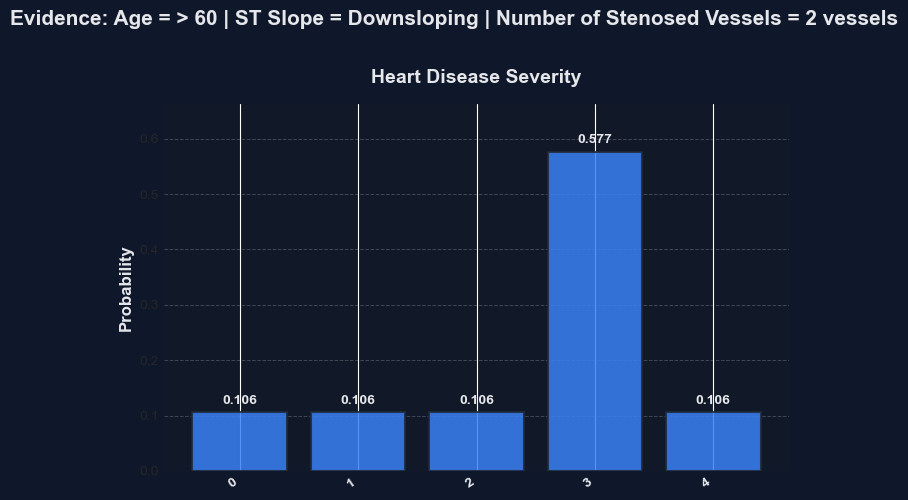

In [12]:
# age: 45-60, slope: downsloping(3), ca: Number of Stenosed Vessels = 2
# Predicting 'num' heart disease severity
evidence = {"age": 2, "slope": 3, "ca": 2}
results, joint_prob, joint_entries = query_bn(
    infer,
    variables=["num"],
    raw_evidence=evidence,
    target_states=None
)

plot_distributions(
    results=results,
    target_map=None,
    evidence=evidence,
    outfile=Path("results/query1_num.png"),
)

### Query-2:
Analysis of the Impact of Gender Differences on Symptom Manifestations
- Query Variable Selection: `Chest Pain Type`
- Evidence Variable Selection: - `Sex` = "Female"
- `Heart Disease Severity` = "HD-3"


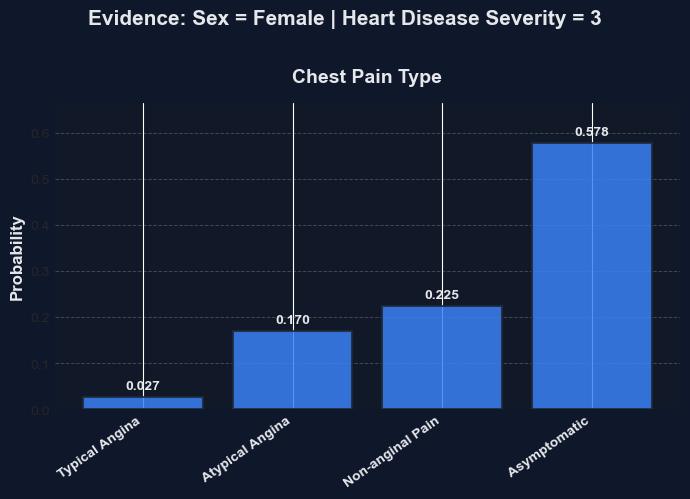

In [13]:
# sex: 0 Female, num: 3 Heart Disease Severity 

evidence = {"sex": 0, "num": 3}

# 2) Query the BN for 'cp' (chest pain type)
results, joint_prob, joint_entries = query_bn(
    infer,
    variables=["cp"],
    raw_evidence=evidence,
    target_states=None
)

plot_distributions(
    results=results,
    target_map=None,
    evidence=evidence,
    outfile=Path("results/query_gender_cp.png"),
)

### Query-3:
Verification of the Synergistic Effect between Cholesterol and Blood Pressure
Query variable selection: `Severity of Heart Disease`
Evidence variable selection:
- `Cholesterol => 239`
- `Resting BP => 140`
- `Age = 45-60`

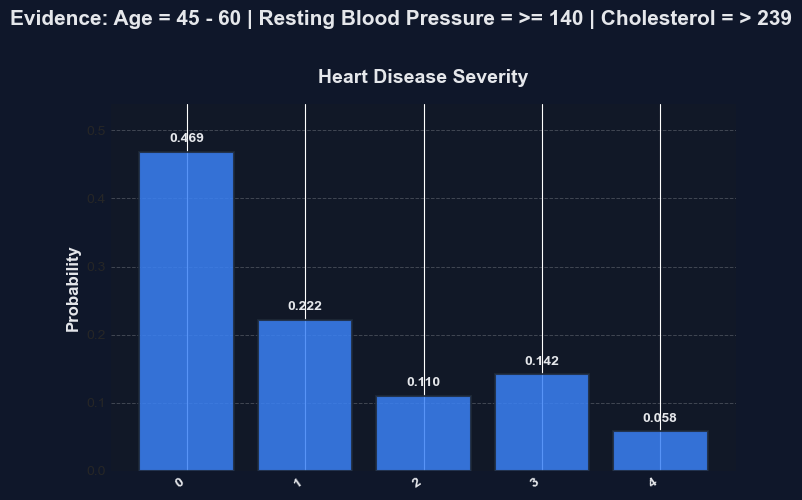

In [14]:
# age: 1 (<45), trestbps/Resting Bp: 1 (<140), chol/Cholesterol: 2 (>=239)

evidence = {"age": 1, "trestbps": 1, "chol": 2}

results, joint_prob, joint_entries = query_bn(
    infer,
    variables=["num"],
    raw_evidence=evidence,
    target_states=None  
)

plot_distributions(
    results=results,
    target_map=None,          
    evidence=evidence,
    outfile=Path("results/query_chol_bp_age.png"),
)

### Query-4:

Evaluation of the diagnostic value of exercise test results
Query variable selection: `Major Vessels`
Evidence variable selection: - `Exercise Angina` = "Yes"
- `ST Depression` = ">1"
- `Thalassemia` = "Reversable Defect"



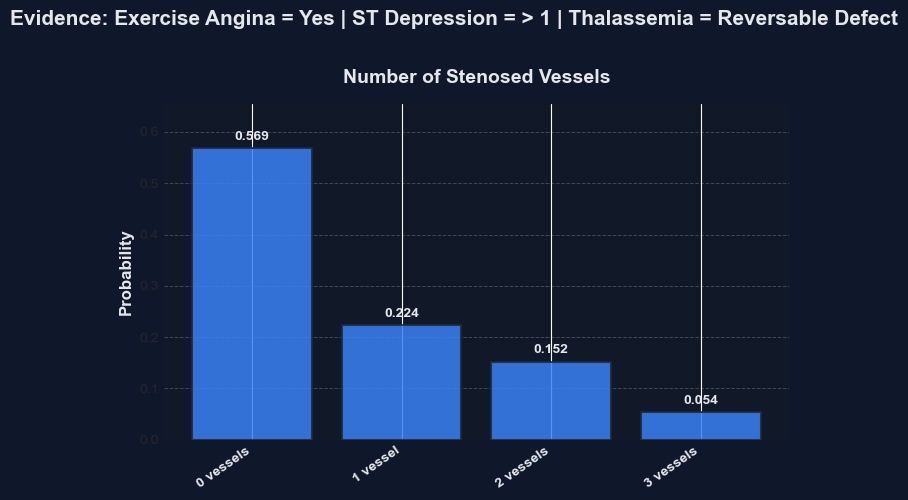

In [15]:
# exang: 1 (Yes), oldpeak: 1 (1.0-Inf), thal: 7 (Reversable Defect)

evidence = {"exang": 1, "oldpeak": 1, "thal": 7}

results, joint_prob, joint_entries = query_bn(
    infer,
    variables=["ca"], # predicting 'ca' number of stenosed vessels
    raw_evidence=evidence, 
    target_states=None  
)

plot_distributions(
    results=results,
    target_map=None,          
    evidence=evidence,
    outfile=Path("results/query4_exercise_test.png"),
)

### Query-5:

Risk assessment of missed diagnosis for atypical manifestations in young patients
Query variable selection: `Severity of Heart Disease`
Evidence variable selection: - `Age` = "<45"
- `Chest Pain Type` = "Asymptomatic"
- `ST Slope` = "Flat"


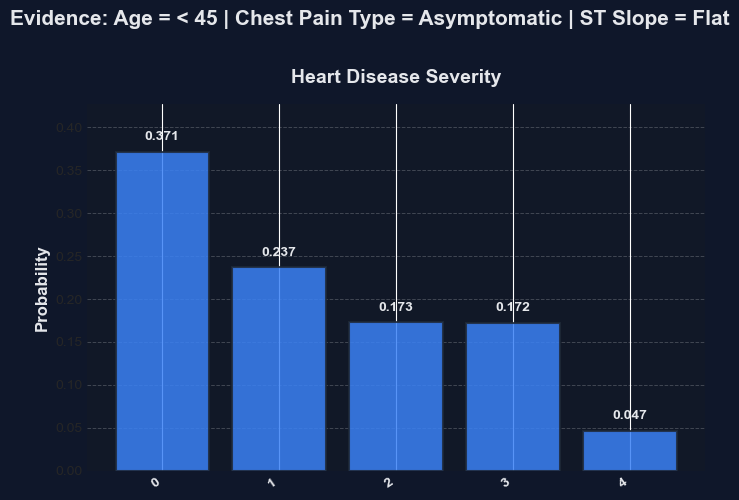

In [ ]:
# age: 0 (<45), cp: 4 (Asymptomatic), slope: 2 (Flat)
evidence = {"age": 0, "cp": 4, "slope": 2}

results, joint_prob, joint_entries = query_bn(
    infer,
    variables=["num"],          
    raw_evidence=evidence,
    target_states=None        
)
# print(pd.Series(results["num"]))

plot_distributions(
    results=results,
    target_map=None,           
    evidence=evidence,
    outfile=Path("results/query_young_atypical.png"),
)

### Query-6:

Sensitivity Comparison of Ultimate Risk Factors
Query Variable Selection: "Heart Disease Severity"
Evidence Variable Combinations (Sequential Queries):
1. Set "Major Vessels" = "3vessels"
2. Set "Thalassemia" = "Fixed Defect"
3. Set "ST Slope" = "Downsloping" 


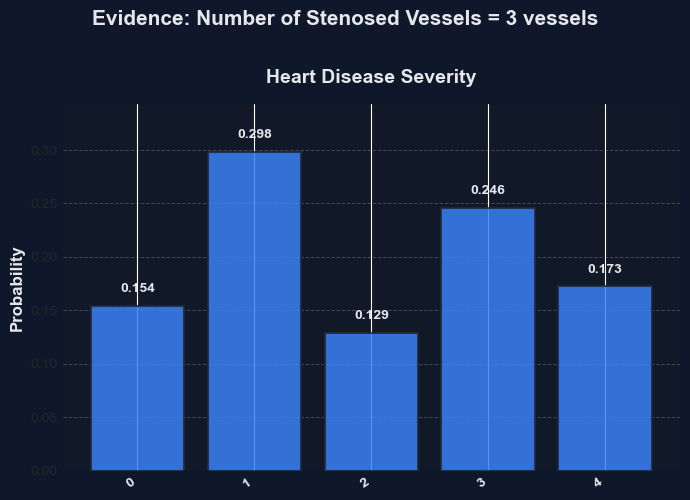

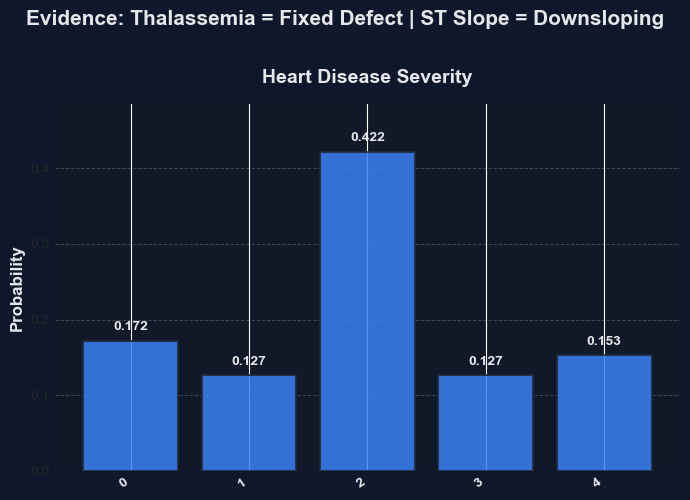

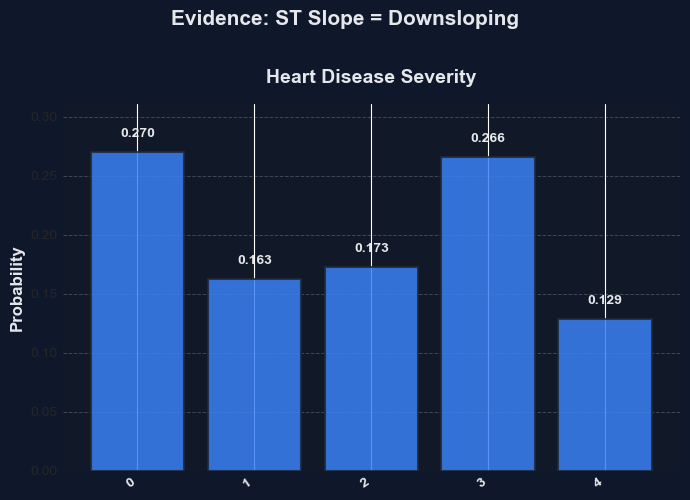

In [17]:
# ca/ = 3 (3 vessels), thal = 6 (Fixed Defect), slope = 3 (Downsloping)
evidence = {"ca": 3}
#thal/Thalassemia 3（Normal）、6（Fixed Defect）、7（Reversible Defect）
result, joint_prob, joint_entries = query_bn(infer, variables=["num"], raw_evidence=evidence)
plot_distributions(results=result,
                target_map=None,
                evidence=evidence,
                outfile=Path("results/sens_ca1.png"))

evidence = {"thal": 6,"slope": 3}
result, joint_prob, joint_entries = query_bn(infer, variables=["num"], raw_evidence=evidence)
plot_distributions(results=result,
                target_map=None,
                evidence=evidence,
                outfile=Path("results/sens_ca2.png"))

evidence = {"slope": 3}
result, joint_prob, joint_entries = query_bn(infer, variables=["num"], raw_evidence=evidence)
plot_distributions(results=result, target_map=None, evidence=evidence,
                    outfile=Path("results/sens_ca3.png"))
